In [93]:
import matplotlib.pyplot as plt
import numpy as np
import re
import wordcloud
import spacy
nlp = spacy.load('en_core_web_sm')
import pandas as pd
import datetime
from tqdm import tqdm

from load_reviews import load_reviews

In [94]:
def unique(l: list) -> list:
    return list(set(l))

In [95]:
reviews_ba = load_reviews("../dataset/BeerAdvocate/reviews.txt", max_entries=1000000).dropna()
reviews_rb = load_reviews("../dataset/RateBeer/ratings.txt", max_entries=1000000).dropna()

reviews = pd.concat([reviews_ba, reviews_rb], ignore_index=True)

Loading reviews from ../dataset/BeerAdvocate/reviews.txt
Number of lines: None


16999998it [00:11, 1523594.58it/s]


Loading reviews from ../dataset/RateBeer/ratings.txt
Number of lines: None


16999998it [00:10, 1593302.93it/s]


In [96]:
dummy = reviews.groupby("user_id").count().sort_values(by="rating", ascending=False)
user_ids = dummy.index.values
user_counts = dummy["rating"].values

# Print the top 10 users
for i in range(10):
    print(f"{user_ids[i]:>24} has {user_counts[i]} reviews")

                   30149 has 10124 reviews
                    5328 has 9128 reviews
                   38926 has 9062 reviews
                   14280 has 7407 reviews
                    1786 has 7217 reviews
                   19400 has 5955 reviews
                    5855 has 5585 reviews
                     195 has 5505 reviews
                  121469 has 5437 reviews
                   41169 has 5180 reviews


In [102]:
USER_INDEX = 0

user_reviews = reviews.query("user_id == @user_ids[@USER_INDEX]")

rating_quantiles = np.quantile(
    a=user_reviews["overall"].values,
    q=[0.25, 0.75]
)

bad_rating = rating_quantiles[0]
good_rating = rating_quantiles[1]

date_quantiles = np.quantile(
    a=user_reviews["date"].values,
    q=[0.25, 0.75]
)

old_date = date_quantiles[0]
recent_date = date_quantiles[1]

print(f"For {user_ids[USER_INDEX]}:")
print(f"A review is considered bad when it has a rating of      <= {bad_rating}")
print(f"A review is considered good when it has a rating of     >= {good_rating}")
print(f"A review is considered old when it was written before   {datetime.datetime.utcfromtimestamp(int(old_date)).strftime('%d %B %Y')}")
print(f"A review is considered recent when it was written after {datetime.datetime.utcfromtimestamp(int(recent_date)).strftime('%d %B %Y')}")

query_old_bad = {"name": "old_bad", "query": "overall <= @bad_rating and date <= @old_date"}
query_old_good = {"name": "old_good", "query": "overall >= @good_rating and date <= @old_date"}
query_recent_bad = {"name": "recent_bad", "query": "overall <= @bad_rating and date >= @recent_date"}
query_recent_good = {"name": "recent_good", "query": "overall >= @good_rating and date >= @recent_date"}

all_adjectives = []
for review in tqdm(user_reviews["text"].values, desc="Extracting adjectives"):
    text =  review.lower()
    # all_adjectives += [token.text for token in nlp(text) if token.pos_ == "ADJ" and token.text.isalpha()]
    all_adjectives += [word for word in text.split() if word.isalpha() and len(word) > 2]

adjectives = {
    "adjectives": unique(all_adjectives),
    "total_counts": [],
    "old_bad" : [],
    "old_good" : [],
    "recent_bad" : [],
    "recent_good" : []
}

texts = " ".join(user_reviews["text"].values).lower()
adjectives["total_counts"] = [texts.lower().count(adj) for adj in unique(all_adjectives)]

for query_index, query_obj in enumerate(tqdm([query_old_bad, query_old_good, query_recent_bad, query_recent_good])):
    specific_reviews = user_reviews.query(query_obj["query"]) 
    review_count = specific_reviews.shape[0]
    texts = " ".join(specific_reviews["text"].values).lower()
    adjectives[query_obj["name"]] = [texts.count(adj) for adj in unique(all_adjectives)]

adjectives_df = pd.DataFrame(adjectives).sort_values(by="total_counts", ascending=False)
adjectives_df["total_counts"] = adjectives_df["old_bad"] + adjectives_df["old_good"] + adjectives_df["recent_bad"] + adjectives_df["recent_good"]
adjectives_df = adjectives_df.query("total_counts >= 10") # NOTE: Arbitrary value
adjectives_df["goodness_score"]   = (adjectives_df["old_good"]    + adjectives_df["recent_good"]) / adjectives_df["total_counts"]
adjectives_df["recentness_score"] = (adjectives_df["recent_good"] + adjectives_df["recent_bad"])  / adjectives_df["total_counts"]

For 30149:
A review is considered bad when it has a rating of      <= 11.0
A review is considered good when it has a rating of     >= 14.0
A review is considered old when it was written before   21 April 2009
A review is considered recent when it was written after 02 July 2015


100%|██████████| 4/4 [00:01<00:00,  2.98it/s]


In [98]:
# Plot worlds with large goodness_score



,adjectives,total_counts,old_bad,old_good,recent_bad,recent_good,goodness_score,recentness_score
635,dsrk,18,0,0,0,18,1.0,1.0
824,compliment,10,0,9,0,1,1.0,0.1
2134,rich,16,0,0,0,16,1.0,1.0
1243,snd,22,0,0,0,22,1.0,1.0
1652,oily,10,0,7,0,3,1.0,0.3
...,...,...,...,...,...,...,...,...
1925,cereal,19,19,0,0,0,0.0,0.0
3352,artificial,27,27,0,0,0,0.0,0.0
1654,fonefan,10,10,0,0,0,0.0,0.0
662,boring,49,49,0,0,0,0.0,0.0


Text(0.5, 1.0, 'recent good reviews')

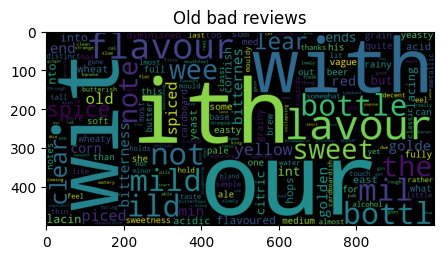

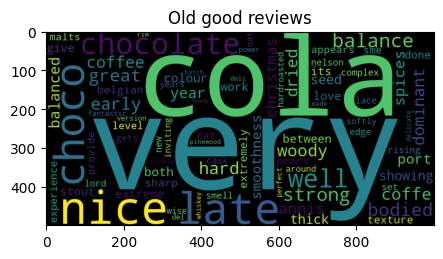

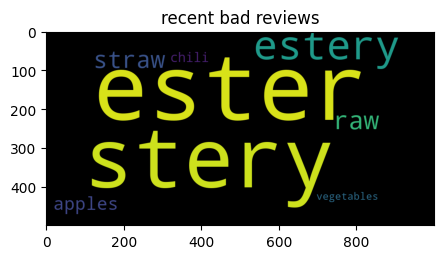

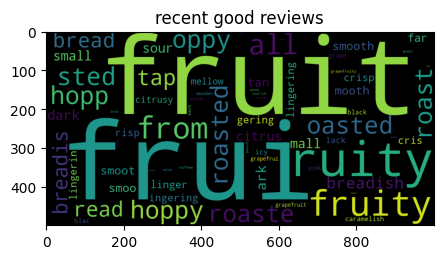

In [103]:
words = adjectives_df.query("old_bad / total_counts >= 0.5")["adjectives"].values
counts = adjectives_df.query("old_bad / total_counts >= 0.5")["old_bad"].values
wc = wordcloud.WordCloud(width = 1000, height = 500).generate_from_frequencies({word: count for word, count in zip(words, counts)})
plt.figure(figsize=(5,4))
plt.imshow(wc)
plt.title("Old bad reviews")


words = adjectives_df.query("old_good / total_counts >= 0.5")["adjectives"].values
counts = adjectives_df.query("old_good / total_counts >= 0.5")["old_bad"].values
wc = wordcloud.WordCloud(width = 1000, height = 500).generate_from_frequencies({word: count for word, count in zip(words, counts)})
plt.figure(figsize=(5,4))
plt.imshow(wc)
plt.title("Old good reviews")


words = adjectives_df.query("recent_bad / total_counts >= 0.5")["adjectives"].values
counts = adjectives_df.query("recent_bad / total_counts >= 0.5")["old_bad"].values
wc = wordcloud.WordCloud(width = 1000, height = 500).generate_from_frequencies({word: count for word, count in zip(words, counts)})
plt.figure(figsize=(5,4))
plt.imshow(wc)
plt.title("recent bad reviews")


words = adjectives_df.query("recent_good / total_counts >= 0.5")["adjectives"].values
counts = adjectives_df.query("recent_good / total_counts >= 0.5")["old_bad"].values
wc = wordcloud.WordCloud(width = 1000, height = 500).generate_from_frequencies({word: count for word, count in zip(words, counts)})
plt.figure(figsize=(5,4))
plt.imshow(wc)
plt.title("recent good reviews")


In [105]:
adjectives_df.query("recent_bad / total_counts >= 0.5")

,adjectives,total_counts,old_bad,old_good,recent_bad,recent_good,goodness_score,recentness_score
2723,ester,342,49,8,208,77,0.248538,0.833333
2188,stery,330,40,5,207,78,0.251515,0.863636
1723,estery,326,37,5,207,77,0.251534,0.871166
3240,raw,49,9,0,33,7,0.142857,0.816327
1331,straw,48,8,0,33,7,0.145833,0.833333
975,chili,18,2,2,11,3,0.277778,0.777778
823,apples,33,4,0,18,11,0.333333,0.878788
1434,vegetables,16,1,0,13,2,0.125000,0.937500
767,skunk,10,0,1,8,1,0.200000,0.900000
2277,skunky,10,0,1,8,1,0.200000,0.900000


In [ ]:
BINS = 10
binned_dates = 